# Process the dataset

***NOTE***: SCRIVERE CODICE DICT

In [94]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms
import clip
import torch
import torch.nn as nn

import os
from pprint import pprint
from copy import deepcopy
from time import time

wordnet_classes = {
    "n01498041": "stingray",
    "n01531178": "goldfinch",
    "n01534433": "junco",
    "n01558993": "American robin",
    "n01580077": "jay",
    "n01614925": "bald eagle",
    "n01616318": "vulture",
    "n01631663": "newt",
    "n01641577": "American bullfrog",
    "n01669191": "box turtle",
    "n01677366": "green iguana",
    "n01687978": "agama",
    "n01694178": "chameleon",
    "n01698640": "American alligator",
    "n01735189": "garter snake",
    "n01770081": "harvestman",
    "n01770393": "scorpion",
    "n01774750": "tarantula",
    "n01784675": "centipede",
    "n01819313": "sulphur-crested cockatoo",
    "n01820546": "lorikeet",
    "n01833805": "hummingbird",
    "n01843383": "toucan",
    "n01847000": "duck",
    "n01855672": "goose",
    "n01882714": "koala",
    "n01910747": "jellyfish",
    "n01914609": "sea anemone",
    "n01924916": "flatworm",
    "n01944390": "snail",
    "n01985128": "crayfish",
    "n01986214": "hermit crab",
    "n02007558": "flamingo",
    "n02009912": "great egret",
    "n02037110": "oystercatcher",
    "n02051845": "pelican",
    "n02077923": "sea lion",
    "n02085620": "Chihuahua",
    "n02099601": "Golden Retriever",
    "n02106550": "Rottweiler",
    "n02106662": "German Shepherd Dog",
    "n02110958": "pug",
    "n02119022": "red fox",
    "n02123394": "Persian cat",
    "n02127052": "lynx",
    "n02129165": "lion",
    "n02133161": "American black bear",
    "n02137549": "mongoose",
    "n02165456": "ladybug",
    "n02174001": "rhinoceros beetle",
    "n02177972": "weevil",
    "n02190166": "fly",
    "n02206856": "bee",
    "n02219486": "ant",
    "n02226429": "grasshopper",
    "n02231487": "stick insect",
    "n02233338": "cockroach",
    "n02236044": "mantis",
    "n02259212": "leafhopper",
    "n02268443": "dragonfly",
    "n02279972": "monarch butterfly",
    "n02280649": "small white",
    "n02281787": "gossamer-winged butterfly",
    "n02317335": "starfish",
    "n02325366": "cottontail rabbit",
    "n02346627": "porcupine",
    "n02356798": "fox squirrel",
    "n02361337": "marmot",
    "n02410509": "bison",
    "n02445715": "skunk",
    "n02454379": "armadillo",
    "n02486410": "baboon",
    "n02492035": "white-headed capuchin",
    "n02504458": "African bush elephant",
    "n02655020": "pufferfish",
    "n02669723": "academic gown",
    "n02672831": "accordion",
    "n02676566": "acoustic guitar",
    "n02690373": "airliner",
    "n02701002": "ambulance",
    "n02730930": "apron",
    "n02777292": "balance beam",
    "n02782093": "balloon",
    "n02787622": "banjo",
    "n02793495": "barn",
    "n02797295": "wheelbarrow",
    "n02802426": "basketball",
    "n02814860": "lighthouse",
    "n02815834": "beaker",
    "n02837789": "bikini",
    "n02879718": "bow",
    "n02883205": "bow tie",
    "n02895154": "breastplate",
    "n02906734": "broom",
    "n02948072": "candle",
    "n02951358": "canoe",
    "n02980441": "castle",
    "n02992211": "cello",
    "n02999410": "chain",
    "n03014705": "chest",
    "n03026506": "Christmas stocking",
    "n03124043": "cowboy boot",
    "n03125729": "cradle",
    "n03187595": "rotary dial telephone",
    "n03196217": "digital clock",
    "n03223299": "doormat",
    "n03250847": "drumstick",
    "n03255030": "dumbbell",
    "n03291819": "envelope",
    "n03325584": "feather boa",
    "n03355925": "flagpole",
    "n03384352": "forklift",
    "n03388043": "fountain",
    "n03417042": "garbage truck",
    "n03443371": "goblet",
    "n03444034": "go-kart",
    "n03445924": "golf cart",
    "n03452741": "grand piano",
    "n03483316": "hair dryer",
    "n03584829": "clothes iron",
    "n03590841": "jack-o'-lantern",
    "n03594945": "jeep",
    "n03617480": "kimono",
    "n03666591": "lighter",
    "n03670208": "limousine",
    "n03717622": "manhole cover",
    "n03720891": "maraca",
    "n03721384": "marimba",
    "n03724870": "mask",
    "n03775071": "mitten",
    "n03788195": "mosque",
    "n03804744": "nail",
    "n03837869": "obelisk",
    "n03840681": "ocarina",
    "n03854065": "organ",
    "n03888257": "parachute",
    "n03891332": "parking meter",
    "n03935335": "piggy bank",
    "n03982430": "billiard table",
    "n04019541": "hockey puck",
    "n04033901": "quill",
    "n04039381": "racket",
    "n04067472": "reel",
    "n04086273": "revolver",
    "n04099969": "rocking chair",
    "n04118538": "rugby ball",
    "n04131690": "salt shaker",
    "n04133789": "sandal",
    "n04141076": "saxophone",
    "n04146614": "school bus",
    "n04147183": "schooner",
    "n04179913": "sewing machine",
    "n04208210": "shovel",
    "n04235860": "sleeping bag",
    "n04252077": "snowmobile",
    "n04252225": "snowplow",
    "n04254120": "soap dispenser",
    "n04270147": "spatula",
    "n04275548": "spider web",
    "n04310018": "steam locomotive",
    "n04317175": "stethoscope",
    "n04344873": "couch",
    "n04347754": "submarine",
    "n04355338": "sundial",
    "n04366367": "suspension bridge",
    "n04376876": "syringe",
    "n04389033": "tank",
    "n04399382": "teddy bear",
    "n04442312": "toaster",
    "n04456115": "torch",
    "n04482393": "tricycle",
    "n04507155": "umbrella",
    "n04509417": "unicycle",
    "n04532670": "viaduct",
    "n04540053": "volleyball",
    "n04554684": "washing machine",
    "n04562935": "water tower",
    "n04591713": "wine bottle",
    "n04606251": "shipwreck",
    "n07583066": "guacamole",
    "n07695742": "pretzel",
    "n07697313": "cheeseburger",
    "n07697537": "hot dog",
    "n07714990": "broccoli",
    "n07718472": "cucumber",
    "n07720875": "bell pepper",
    "n07734744": "mushroom",
    "n07749582": "lemon",
    "n07753592": "banana",
    "n07760859": "custard apple",
    "n07768694": "pomegranate",
    "n07831146": "carbonara",
    "n09229709": "bubble",
    "n09246464": "cliff",
    "n09472597": "volcano",
    "n09835506": "baseball player",
    "n11879895": "rapeseed",
    "n12057211": "yellow lady's slipper",
    "n12144580": "corn",
    "n12267677": "acorn"
}

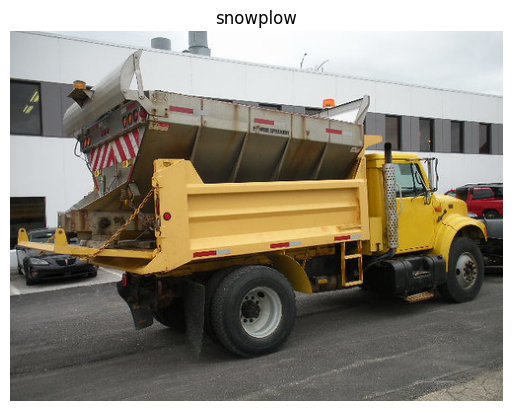

In [95]:

# def read_data(classnames, image_dir):
#     for folder in os.listdir(image_dir):
#         for filename in os.listdir(os.path.join(image_dir, folder)):
#             if filename.endswith(".png") or filename.endswith(".jpg"):
#                 classname = classnames[filename.split("_")[0]]
#                 impath = os.path.join(image_dir, filename)
#                 item = Datum(impath=impath, label=0, classname=classname)
#                 yield item

def pick_random_image(image_dir):
    folder = np.random.choice(os.listdir(image_dir))
    filename = np.random.choice(os.listdir(os.path.join(image_dir, folder)))
    impath = os.path.join(image_dir, folder, filename)
    return impath, folder

ROOT = "./imagenet-a"

image, key_label = pick_random_image(ROOT)

label = wordnet_classes[key_label]

# show image

image = Image.open(image)
plt.imshow(image)
plt.title(f"{label}")
plt.axis("off")
plt.show()

## Utils


In [96]:
def complex_random_augmentation(image):
    # Lista di trasformazioni potenzialmente applicabili
    transform_list = [
        transforms.RandomHorizontalFlip(p=0.5),  # Flip orizzontale con 50% di probabilità
        transforms.RandomVerticalFlip(p=0.2),    # Flip verticale con 20% di probabilità
        transforms.RandomRotation(45),           # Rotazione casuale di ±45 gradi
        transforms.RandomApply([                 # Applica con probabilità del 30% la seguente trasformazione
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
        ], p=0.3),
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.5, 1.0), ratio=(0.75, 1.33)),  # Crop ridimensionato casuale
        transforms.RandomGrayscale(p=0.1),       # Conversione in scala di grigi con 10% di probabilità
        transforms.RandomApply([                 # Applica con probabilità del 40% la seguente trasformazione
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        ], p=0.4)
    ]

    # Componi tutte le trasformazioni
    augmentation = transforms.Compose(transform_list)

    # Applica le trasformazioni all'immagine
    augmented_image = augmentation(image)
    return augmented_image

def visualize_images(images):
    num_images = len(images)
    cols = 4  # Definisci il numero di colonne per la griglia di subplot
    rows = (num_images + cols - 1) // cols  # Calcola il numero di righe necessarie

    plt.figure(figsize=(32, rows * 4))  # Modifica l'altezza in base al numero di righe

    for i, image in enumerate(images):
        # Subplot per l'immagine
        plt.subplot(rows, cols * 2, 2 * i + 1)
        plt.imshow(image)
        plt.axis("off")

    # plt.subplots_adjust(wspace=0.1, hspace=0.5)  # Adjust lo spazio tra i subplot
    plt.show()

def visualize_results(image, top_probs, top_labels):
    num_images = len(image)
    cols = 4  # Definisci il numero di colonne per la griglia di subplot
    rows = (num_images + cols - 1) // cols  # Calcola il numero di righe necessarie

    plt.figure(figsize=(16, rows * 4))  # Modifica l'altezza in base al numero di righe

    for i, image in enumerate(image):
        # Subplot per l'immagine
        plt.subplot(rows, cols * 2, 2 * i + 1)
        plt.imshow(image)
        plt.axis("off")

        # Subplot per il grafico a barre delle probabilità
        plt.subplot(rows, cols * 2, 2 * i + 2)
        y = np.arange(top_probs.shape[-1])
        plt.grid()
        plt.barh(y, top_probs[i])
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        plt.yticks(y, [list(wordnet_classes.values())[index] for index in top_labels[i].numpy()])
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust lo spazio tra i subplot
    plt.show()

def bar_graph(top_labels, top_probs):
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [list(wordnet_classes.values())[index] for index in top_labels.numpy()])
    plt.xlabel("probability")
    plt.show()

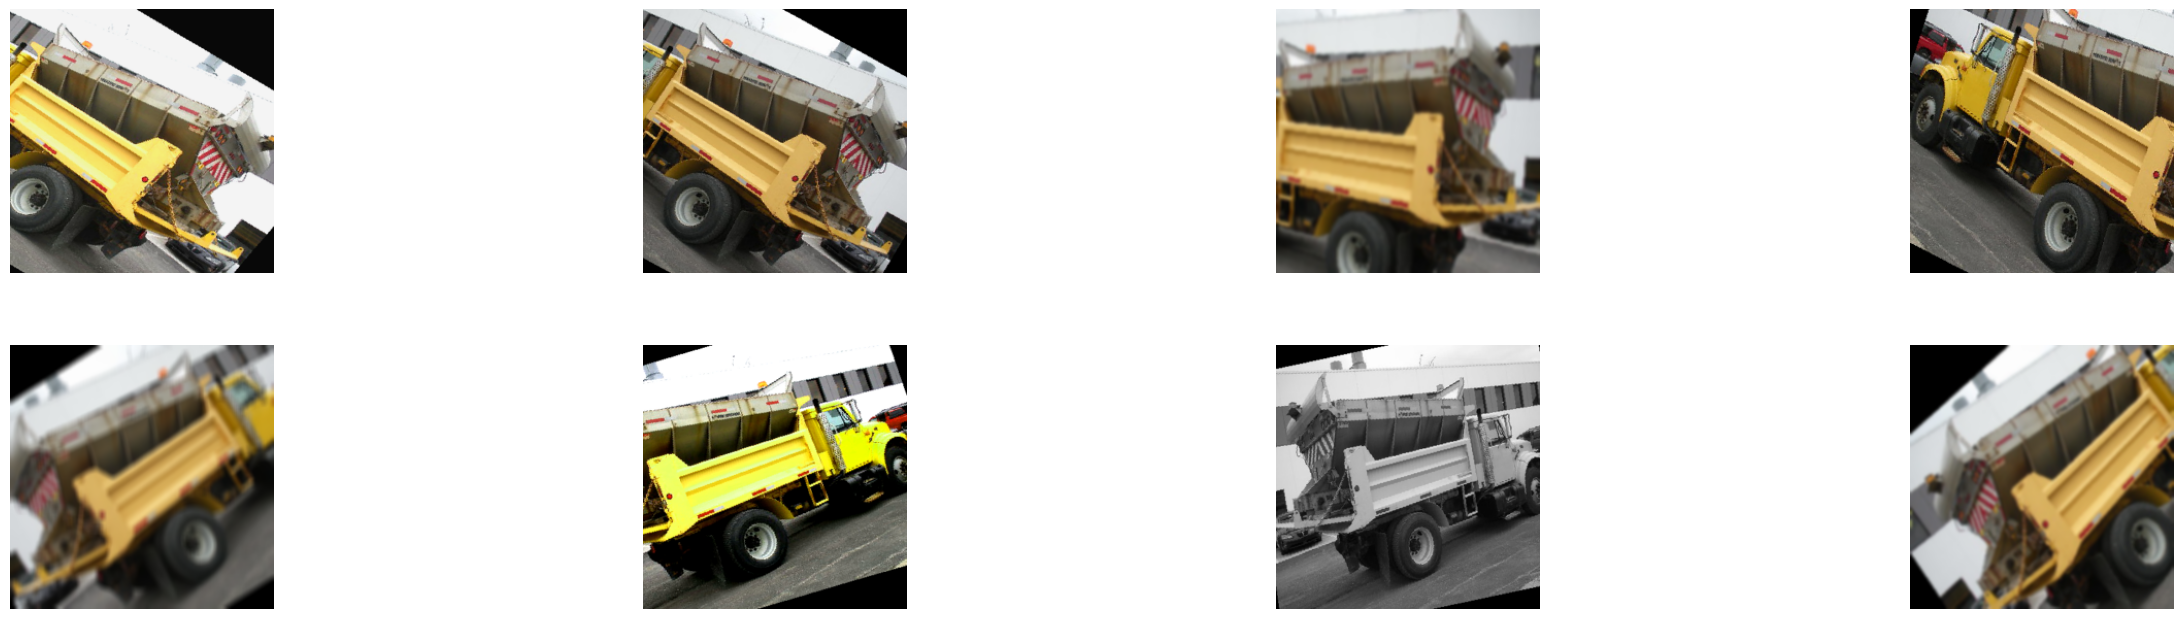

In [97]:
augment_images = [complex_random_augmentation(image) for _ in range(8)]
visualize_images(augment_images)

# LOAD THE MODEL


In [98]:
model, preprocess = clip.load("RN50", device=0)

# ENCODE *

In [99]:
text_descriptions = [f"This is a photo of a {label}" for label in wordnet_classes.values()]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [100]:
_augment_images = [preprocess(image) for image in augment_images]
augment_images_input = torch.tensor(np.stack(_augment_images)).cuda()

with torch.no_grad():
    augment_images_features = model.encode_image(augment_images_input).float()
    text_features = model.encode_text(text_tokens).float()
    augment_images_features /= augment_images_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
text_probs = (100.0 * augment_images_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)
probs, labels_predicted = text_probs.cpu().topk(len(wordnet_classes.values()), dim=-1)

# DISPLAY THE RESULTS

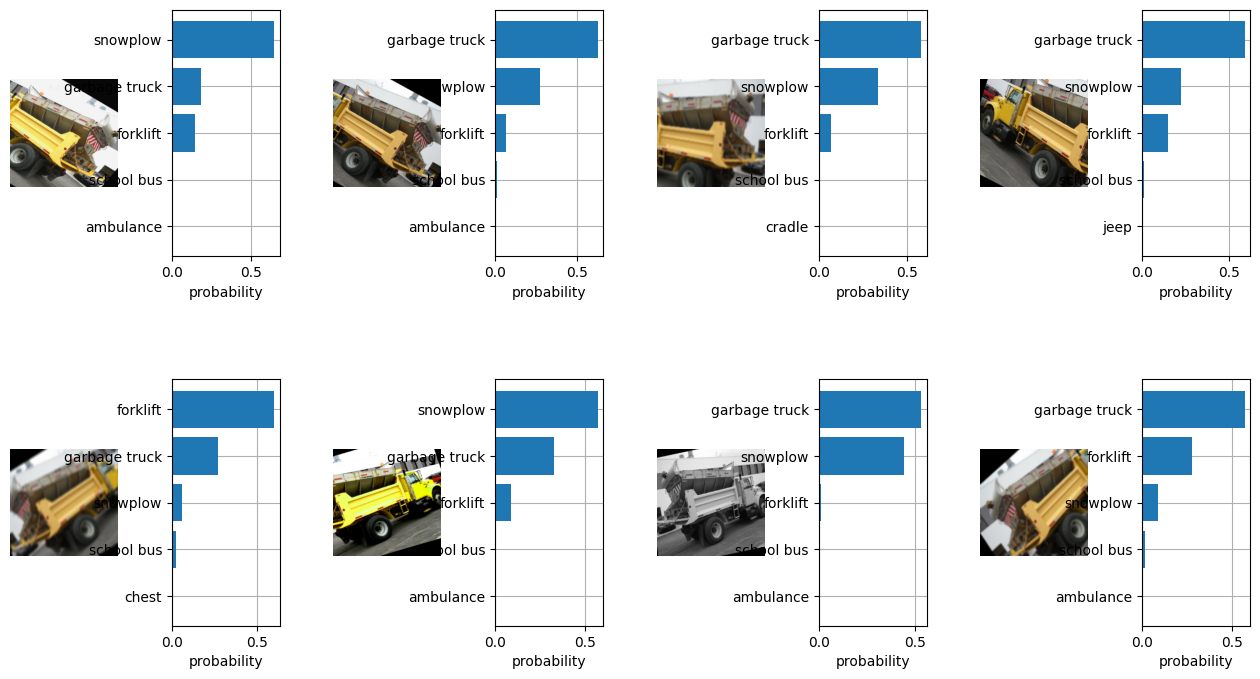

snowplow


In [101]:
visualize_results(augment_images, top_probs, top_labels)
print(label)

# CONFIDENCE SELECTION

- If a prediction is grater than 0.3 we keep the results
- Otherwise take the mean of all the predictions and if it is less than 0.2 discard it

In [102]:
# Find the entropy of the probabilities [taken from paper tpt]
def calculate_entropy(tensor_top_prob, top=4):
    entropy = - (tensor_top_prob.softmax(-1) * tensor_top_prob.log_softmax(-1)).sum(-1)
    idx = torch.argsort(entropy, descending=False)[:top]
    return tensor_top_prob[idx], idx


selected, indexs = calculate_entropy(top_probs)
print("selected ones: ", selected)
print(indexs)

selected ones:  tensor([[0.6468, 0.1846, 0.1454, 0.0095, 0.0021],
        [0.6259, 0.2744, 0.0640, 0.0093, 0.0039],
        [0.5341, 0.4411, 0.0130, 0.0027, 0.0014],
        [0.6051, 0.2726, 0.0627, 0.0264, 0.0048]])
tensor([0, 1, 6, 4])


# COMPUTE THE AVERAGE OF THE PREDICTION

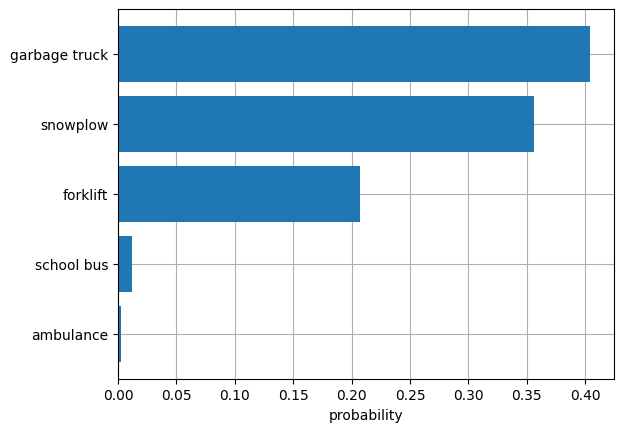

In [103]:
def compute_average_prediction(indexes, probs):
    sum_probs = 0
    for i in indexes:
        sum_probs += probs[i]
    return sum_probs / len(indexes)

# reorder the prob array according to the labels_predicted array
def reorder_probabilities(labels_predicted, distribution_list):
    ordered_dist = torch.zeros_like(distribution_list)
    for i, distribution in enumerate(distribution_list):
        for j in range(len(distribution)):
            ordered_dist[i][labels_predicted[i][j]] = distribution[j]
            
    return ordered_dist

probs_ordered = reorder_probabilities(labels_predicted, probs)

average_prediction = compute_average_prediction(indexs, probs_ordered)
top_probs, top_labels = average_prediction.cpu().topk(5, dim=-1)
bar_graph(top_labels, top_probs)

# COOP CLIP MODEL
## Tokenizer

In [104]:
from clip.simple_tokenizer import SimpleTokenizer
from clip import tokenize, load
from torch.backends import cudnn
from torchvision.datasets import ImageFolder



PRETRAINED = False
PATH_WEIGHTS = None
ARCHITECTURE = "RN50"

DEVICE = "cuda:0"
GPU = 0

CLIP_RESOLUTION = 224
TTA_STEP = 1

_tokenizer = SimpleTokenizer()

## Encode the text

In [105]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection

    def forward(self, prompts, tokenized_prompts):
        print(prompts.shape)
        x = prompts + self.positional_embedding
        x = x.permute(1, 0, 2)  # [batch_size, n_ctx, transformer.width] -> [n_ctx, batch_size, transformer.width]
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # [n_ctx, batch_size, transformer.width] -> [batch_size, n_ctx, transformer.width]
        x = self.ln_final(x)

        # Take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

## Promp Learner

In [106]:
class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, batch_size=None, n_ctx=16, ctx_init=None, ctx_position='end', learned_cls=False):
        super().__init__()
        n_cls = len(classnames)
        self.learned_cls = learned_cls
        dtype = clip_model.dtype
        self.dtype = dtype
        self.device = clip_model.visual.conv1.weight.device
        ctx_dim = clip_model.ln_final.weight.shape[0]
        self.ctx_dim = ctx_dim
        self.batch_size = batch_size

        if ctx_init:
            # use given words to initialize context vectors
            print("Initializing the contect with given words: [{}]".format(ctx_init))
            ctx_init = ctx_init.replace("_", " ")
            if '[CLS]' in ctx_init:
                ctx_list = ctx_init.split(" ")
                split_idx = ctx_list.index("[CLS]")
                ctx_init = ctx_init.replace("[CLS] ", "")
                ctx_position = "middle"
            else:
                split_idx = None
            self.split_idx = split_idx
            n_ctx = len(ctx_init.split(" "))
            prompt = tokenize(ctx_init).to(self.device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            print("Random initialization: initializing a generic context")
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)
        
        self.prompt_prefix = prompt_prefix

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        # batch-wise prompt tuning for test-time adaptation
        if self.batch_size is not None: 
            ctx_vectors = ctx_vectors.repeat(batch_size, 1, 1)  #(N, L, D)
        self.ctx_init_state = ctx_vectors.detach().clone()
        self.ctx = nn.Parameter(ctx_vectors) # to be optimized

        if not self.learned_cls:
            classnames = [name.replace("_", " ") for name in classnames]
            name_lens = [len(_tokenizer.encode(name)) for name in classnames]
            prompts = [prompt_prefix + " " + name + "." for name in classnames]
        else:
            print("Random initialization: initializing a learnable class token")
            cls_vectors = torch.empty(n_cls, 1, ctx_dim, dtype=dtype) # assume each learnable cls_token is only 1 word
            nn.init.normal_(cls_vectors, std=0.02)
            cls_token = "X"
            name_lens = [1 for _ in classnames]
            prompts = [prompt_prefix + " " + cls_token + "." for _ in classnames]

            self.cls_init_state = cls_vectors.detach().clone()
            self.cls = nn.Parameter(cls_vectors) # to be optimized

        tokenized_prompts = torch.cat([tokenize(p) for p in prompts]).to(self.device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        if self.learned_cls:
            self.register_buffer("token_suffix", embedding[:, 1 + n_ctx + 1:, :])  # ..., EOS
        else:
            self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS

        self.ctx_init = ctx_init
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens
        self.class_token_position = ctx_position
        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.classnames = classnames

    def reset(self):
        ctx_vectors = self.ctx_init_state
        self.ctx.copy_(ctx_vectors) # to be optimized
        if self.learned_cls:
            cls_vectors = self.cls_init_state
            self.cls.copy_(cls_vectors)

    def reset_classnames(self, classnames):
        self.n_cls = len(classnames)
        if not self.learned_cls:
            classnames = [name.replace("_", " ") for name in classnames]
            name_lens = [len(_tokenizer.encode(name)) for name in classnames]
            prompts = [self.prompt_prefix + " " + name + "." for name in classnames]
        else:
            cls_vectors = torch.empty(self.n_cls, 1, self.ctx_dim, dtype=self.dtype) # assume each learnable cls_token is only 1 word
            nn.init.normal_(cls_vectors, std=0.02)
            cls_token = "X"
            name_lens = [1 for _ in classnames]
            prompts = [self.prompt_prefix + " " + cls_token + "." for _ in classnames]
            # TODO: re-init the cls parameters
            # self.cls = nn.Parameter(cls_vectors) # to be optimized
            self.cls_init_state = cls_vectors.detach().clone()
        tokenized_prompts = torch.cat([tokenize(p) for p in prompts]).to(self.device)

        clip, _ = load(ARCHITECTURE)

        with torch.no_grad():
            embedding = clip.token_embedding(tokenized_prompts).type(self.dtype)

        self.token_prefix = embedding[:, :1, :]
        self.token_suffix = embedding[:, 1 + self.n_ctx :, :]  # CLS, EOS

        self.name_lens = name_lens
        self.tokenized_prompts = tokenized_prompts
        self.classnames = classnames

    def forward(self, init=None):
        # the init will be used when computing CLIP directional loss
        if init is not None:
            ctx = init
        else:
            ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        elif not ctx.size()[0] == self.n_cls:
            ctx = ctx.unsqueeze(1).expand(-1, self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix
        if self.batch_size is not None: 
            # This way only works for single-gpu setting (could pass batch size as an argument for forward())
            prefix = prefix.repeat(self.batch_size, 1, 1, 1)
            suffix = suffix.repeat(self.batch_size, 1, 1, 1)

        if self.learned_cls:
            assert self.class_token_position == "end"
        if self.class_token_position == "end":
            if self.learned_cls:
                cls = self.cls
                prompts = torch.cat(
                    [
                        prefix,  # (n_cls, 1, dim)
                        ctx,     # (n_cls, n_ctx, dim)
                        cls,     # (n_cls, 1, dim)
                        suffix,  # (n_cls, *, dim)
                    ],
                    dim=-2,
                )
            else:
                prompts = torch.cat(
                    [
                        prefix,  # (n_cls, 1, dim)
                        ctx,     # (n_cls, n_ctx, dim)
                        suffix,  # (n_cls, *, dim)
                    ],
                    dim=-2,
                )
        elif self.class_token_position == "middle":
            # TODO: to work with a batch of prompts
            if self.split_idx is not None:
                half_n_ctx = self.split_idx # split the ctx at the position of [CLS] in `ctx_init`
            else:
                half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]
                prompt = torch.cat(
                    [
                        prefix_i,     # (1, 1, dim)
                        ctx_i_half1,  # (1, n_ctx//2, dim)
                        class_i,      # (1, name_len, dim)
                        ctx_i_half2,  # (1, n_ctx//2, dim)
                        suffix_i,     # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        elif self.class_token_position == "front":
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i = ctx[i : i + 1, :, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        class_i,   # (1, name_len, dim)
                        ctx_i,     # (1, n_ctx, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        else:
            raise ValueError

        return prompts

## Create our CLIP

In [107]:
class OurCLIP(nn.Module):
    def __init__(self, classnames, n_ctx, ctx_init, class_token_position):
        super().__init__()
        clip_model, _ = clip.load(ARCHITECTURE)
        # clip_model = clip_model.cpu()
        clip_model = clip_model.float()
        self.prompt_learner = PromptLearner(clip_model, classnames, n_ctx, ctx_init, class_token_position)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale

    def forward(self, image):
        image_features = self.image_encoder(image)
        print("1")
        prompts = self.prompt_learner()
        print("2")
        tokenized_prompts = self.tokenized_prompts
        print("3")
        
        text_features = self.text_encoder(prompts, tokenized_prompts)
        print("4")

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        print("5")
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        print("6")
        logit_scale = self.logit_scale.exp()
        print("7")
        logits = logit_scale * image_features @ text_features.t()

        return logits
    
    def reset_classnames(self, classnames):
        self.prompt_learner.reset_classnames(classnames)
        
    def reset(self):
        self.prompt_learner.reset()

## LOAD THE COOP MODEL

In [108]:
n_ctx = 4
lr = 1e-4

model = OurCLIP(wordnet_classes.values(), n_ctx, "", "end")

if PRETRAINED:
    pretrained_ctx = torch.load(PATH_WEIGHTS)['state_dict']['ctx']
    assert pretrained_ctx.size()[0] == n_ctx, "The number of context words does not match the pretrained model"
    with torch.no_grad():
        model.prompt_learner[0].ctx.copy_(pretrained_ctx)
        model.prompt_learner[0].ctx_init_state = pretrained_ctx

model_state = None

for name, param in model.named_parameters():
    if "prompt_learner" not in name:
        param.requires_grad_(False)     # Freeze the visual backbone
        
print("=> Model created: visual backbone {}".format(ARCHITECTURE))

torch.cuda.set_device(GPU)
model = model.cuda(GPU)

trainable_param = model.prompt_learner.parameters()
optimizer = torch.optim.AdamW(trainable_param, lr)
optim_state = deepcopy(optimizer.state_dict())

# setup automatic mixed-precision (Amp) loss scaling
scaler = torch.cuda.amp.GradScaler(init_scale=1000)

print('=> Using native Torch AMP. Training in mixed precision.')

cudnn.benchmark = True

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                     std=[0.26862954, 0.26130258, 0.27577711])

Initializing the contect with given words: [end]
Initial context: "end"
Number of context words (tokens): 1
=> Model created: visual backbone RN50
=> Using native Torch AMP. Training in mixed precision.


## GOOGLE FUNCTION FOR AUG

In [109]:
# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Base augmentations operators."""
from PIL import ImageOps, ImageEnhance

# ImageNet code should change this value
IMAGE_SIZE = 224


def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / 10)


def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval.

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / 10.


def sample_level(n):
  return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
  return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
  return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
  level = int_parameter(sample_level(level), 4)
  return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
  degrees = int_parameter(sample_level(level), 30)
  if np.random.uniform() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
  level = int_parameter(sample_level(level), 256)
  return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

## CREATE THE DATALOADER

In [110]:
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

class AugMixAugmenter(object):
    def __init__(self, base_transform, preprocess, n_views=2, augmix=False, 
                    severity=1):
        self.base_transform = base_transform
        self.preprocess = preprocess
        self.n_views = n_views
        if augmix:
            self.aug_list = augmentations.augmentations
        else:
            self.aug_list = []
        self.severity = severity
        
    def __call__(self, x):
        image = self.preprocess(self.base_transform(x))
        views = [augmix(x, self.preprocess, self.aug_list, self.severity) for _ in range(self.n_views)]
        return [image] + views

def augmix(image, preprocess, aug_list, severity=1):
    preaugment = get_preaugment()
    x_orig = preaugment(image)
    x_processed = preprocess(x_orig)
    if len(aug_list) == 0:
        return x_processed
    w = np.float32(np.random.dirichlet([1.0, 1.0, 1.0]))
    m = np.float32(np.random.beta(1.0, 1.0))

    mix = torch.zeros_like(x_processed)
    for i in range(3):
        x_aug = x_orig.copy()
        for _ in range(np.random.randint(1, 4)):
            x_aug = np.random.choice(aug_list)(x_aug, severity)
        mix += w[i] * preprocess(x_aug)
    mix = m * x_processed + (1 - m) * mix
    return mix

def get_preaugment():
    return transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
        ])

thousand_k_to_200 = {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1, 10: -1, 11: 1, 12: -1, 13: 2, 14: -1, 15: 3, 16: -1, 17: 4, 18: -1, 19: -1, 20: -1, 21: -1, 22: 5, 23: 6, 24: -1, 25: -1, 26: -1, 27: 7, 28: -1, 29: -1, 30: 8, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: 9, 38: -1, 39: 10, 40: -1, 41: -1, 42: 11, 43: -1, 44: -1, 45: -1, 46: -1, 47: 12, 48: -1, 49: -1, 50: 13, 51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: 14, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: 15, 71: 16, 72: -1, 73: -1, 74: -1, 75: -1, 76: 17, 77: -1, 78: -1, 79: 18, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: 19, 90: 20, 91: -1, 92: -1, 93: -1, 94: 21, 95: -1, 96: 22, 97: 23, 98: -1, 99: 24, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: 25, 106: -1, 107: 26, 108: 27, 109: -1, 110: 28, 111: -1, 112: -1, 113: 29, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: 30, 125: 31, 126: -1, 127: -1, 128: -1, 129: -1, 130: 32, 131: -1, 132: 33, 133: -1, 134: -1, 135: -1, 136: -1, 137: -1, 138: -1, 139: -1, 140: -1, 141: -1, 142: -1, 143: 34, 144: 35, 145: -1, 146: -1, 147: -1, 148: -1, 149: -1, 150: 36, 151: 37, 152: -1, 153: -1, 154: -1, 155: -1, 156: -1, 157: -1, 158: -1, 159: -1, 160: -1, 161: -1, 162: -1, 163: -1, 164: -1, 165: -1, 166: -1, 167: -1, 168: -1, 169: -1, 170: -1, 171: -1, 172: -1, 173: -1, 174: -1, 175: -1, 176: -1, 177: -1, 178: -1, 179: -1, 180: -1, 181: -1, 182: -1, 183: -1, 184: -1, 185: -1, 186: -1, 187: -1, 188: -1, 189: -1, 190: -1, 191: -1, 192: -1, 193: -1, 194: -1, 195: -1, 196: -1, 197: -1, 198: -1, 199: -1, 200: -1, 201: -1, 202: -1, 203: -1, 204: -1, 205: -1, 206: -1, 207: 38, 208: -1, 209: -1, 210: -1, 211: -1, 212: -1, 213: -1, 214: -1, 215: -1, 216: -1, 217: -1, 218: -1, 219: -1, 220: -1, 221: -1, 222: -1, 223: -1, 224: -1, 225: -1, 226: -1, 227: -1, 228: -1, 229: -1, 230: -1, 231: -1, 232: -1, 233: -1, 234: 39, 235: 40, 236: -1, 237: -1, 238: -1, 239: -1, 240: -1, 241: -1, 242: -1, 243: -1, 244: -1, 245: -1, 246: -1, 247: -1, 248: -1, 249: -1, 250: -1, 251: -1, 252: -1, 253: -1, 254: 41, 255: -1, 256: -1, 257: -1, 258: -1, 259: -1, 260: -1, 261: -1, 262: -1, 263: -1, 264: -1, 265: -1, 266: -1, 267: -1, 268: -1, 269: -1, 270: -1, 271: -1, 272: -1, 273: -1, 274: -1, 275: -1, 276: -1, 277: 42, 278: -1, 279: -1, 280: -1, 281: -1, 282: -1, 283: 43, 284: -1, 285: -1, 286: -1, 287: 44, 288: -1, 289: -1, 290: -1, 291: 45, 292: -1, 293: -1, 294: -1, 295: 46, 296: -1, 297: -1, 298: 47, 299: -1, 300: -1, 301: 48, 302: -1, 303: -1, 304: -1, 305: -1, 306: 49, 307: 50, 308: 51, 309: 52, 310: 53, 311: 54, 312: -1, 313: 55, 314: 56, 315: 57, 316: -1, 317: 58, 318: -1, 319: 59, 320: -1, 321: -1, 322: -1, 323: 60, 324: 61, 325: -1, 326: 62, 327: 63, 328: -1, 329: -1, 330: 64, 331: -1, 332: -1, 333: -1, 334: 65, 335: 66, 336: 67, 337: -1, 338: -1, 339: -1, 340: -1, 341: -1, 342: -1, 343: -1, 344: -1, 345: -1, 346: -1, 347: 68, 348: -1, 349: -1, 350: -1, 351: -1, 352: -1, 353: -1, 354: -1, 355: -1, 356: -1, 357: -1, 358: -1, 359: -1, 360: -1, 361: 69, 362: -1, 363: 70, 364: -1, 365: -1, 366: -1, 367: -1, 368: -1, 369: -1, 370: -1, 371: -1, 372: 71, 373: -1, 374: -1, 375: -1, 376: -1, 377: -1, 378: 72, 379: -1, 380: -1, 381: -1, 382: -1, 383: -1, 384: -1, 385: -1, 386: 73, 387: -1, 388: -1, 389: -1, 390: -1, 391: -1, 392: -1, 393: -1, 394: -1, 395: -1, 396: -1, 397: 74, 398: -1, 399: -1, 400: 75, 401: 76, 402: 77, 403: -1, 404: 78, 405: -1, 406: -1, 407: 79, 408: -1, 409: -1, 410: -1, 411: 80, 412: -1, 413: -1, 414: -1, 415: -1, 416: 81, 417: 82, 418: -1, 419: -1, 420: 83, 421: -1, 422: -1, 423: -1, 424: -1, 425: 84, 426: -1, 427: -1, 428: 85, 429: -1, 430: 86, 431: -1, 432: -1, 433: -1, 434: -1, 435: -1, 436: -1, 437: 87, 438: 88, 439: -1, 440: -1, 441: -1, 442: -1, 443: -1, 444: -1, 445: 89, 446: -1, 447: -1, 448: -1, 449: -1, 450: -1, 451: -1, 452: -1, 453: -1, 454: -1, 455: -1, 456: 90, 457: 91, 458: -1, 459: -1, 460: -1, 461: 92, 462: 93, 463: -1, 464: -1, 465: -1, 466: -1, 467: -1, 468: -1, 469: -1, 470: 94, 471: -1, 472: 95, 473: -1, 474: -1, 475: -1, 476: -1, 477: -1, 478: -1, 479: -1, 480: -1, 481: -1, 482: -1, 483: 96, 484: -1, 485: -1, 486: 97, 487: -1, 488: 98, 489: -1, 490: -1, 491: -1, 492: 99, 493: -1, 494: -1, 495: -1, 496: 100, 497: -1, 498: -1, 499: -1, 500: -1, 501: -1, 502: -1, 503: -1, 504: -1, 505: -1, 506: -1, 507: -1, 508: -1, 509: -1, 510: -1, 511: -1, 512: -1, 513: -1, 514: 101, 515: -1, 516: 102, 517: -1, 518: -1, 519: -1, 520: -1, 521: -1, 522: -1, 523: -1, 524: -1, 525: -1, 526: -1, 527: -1, 528: 103, 529: -1, 530: 104, 531: -1, 532: -1, 533: -1, 534: -1, 535: -1, 536: -1, 537: -1, 538: -1, 539: 105, 540: -1, 541: -1, 542: 106, 543: 107, 544: -1, 545: -1, 546: -1, 547: -1, 548: -1, 549: 108, 550: -1, 551: -1, 552: 109, 553: -1, 554: -1, 555: -1, 556: -1, 557: 110, 558: -1, 559: -1, 560: -1, 561: 111, 562: 112, 563: -1, 564: -1, 565: -1, 566: -1, 567: -1, 568: -1, 569: 113, 570: -1, 571: -1, 572: 114, 573: 115, 574: -1, 575: 116, 576: -1, 577: -1, 578: -1, 579: 117, 580: -1, 581: -1, 582: -1, 583: -1, 584: -1, 585: -1, 586: -1, 587: -1, 588: -1, 589: 118, 590: -1, 591: -1, 592: -1, 593: -1, 594: -1, 595: -1, 596: -1, 597: -1, 598: -1, 599: -1, 600: -1, 601: -1, 602: -1, 603: -1, 604: -1, 605: -1, 606: 119, 607: 120, 608: -1, 609: 121, 610: -1, 611: -1, 612: -1, 613: -1, 614: 122, 615: -1, 616: -1, 617: -1, 618: -1, 619: -1, 620: -1, 621: -1, 622: -1, 623: -1, 624: -1, 625: -1, 626: 123, 627: 124, 628: -1, 629: -1, 630: -1, 631: -1, 632: -1, 633: -1, 634: -1, 635: -1, 636: -1, 637: -1, 638: -1, 639: -1, 640: 125, 641: 126, 642: 127, 643: 128, 644: -1, 645: -1, 646: -1, 647: -1, 648: -1, 649: -1, 650: -1, 651: -1, 652: -1, 653: -1, 654: -1, 655: -1, 656: -1, 657: -1, 658: 129, 659: -1, 660: -1, 661: -1, 662: -1, 663: -1, 664: -1, 665: -1, 666: -1, 667: -1, 668: 130, 669: -1, 670: -1, 671: -1, 672: -1, 673: -1, 674: -1, 675: -1, 676: -1, 677: 131, 678: -1, 679: -1, 680: -1, 681: -1, 682: 132, 683: -1, 684: 133, 685: -1, 686: -1, 687: 134, 688: -1, 689: -1, 690: -1, 691: -1, 692: -1, 693: -1, 694: -1, 695: -1, 696: -1, 697: -1, 698: -1, 699: -1, 700: -1, 701: 135, 702: -1, 703: -1, 704: 136, 705: -1, 706: -1, 707: -1, 708: -1, 709: -1, 710: -1, 711: -1, 712: -1, 713: -1, 714: -1, 715: -1, 716: -1, 717: -1, 718: -1, 719: 137, 720: -1, 721: -1, 722: -1, 723: -1, 724: -1, 725: -1, 726: -1, 727: -1, 728: -1, 729: -1, 730: -1, 731: -1, 732: -1, 733: -1, 734: -1, 735: -1, 736: 138, 737: -1, 738: -1, 739: -1, 740: -1, 741: -1, 742: -1, 743: -1, 744: -1, 745: -1, 746: 139, 747: -1, 748: -1, 749: 140, 750: -1, 751: -1, 752: 141, 753: -1, 754: -1, 755: -1, 756: -1, 757: -1, 758: 142, 759: -1, 760: -1, 761: -1, 762: -1, 763: 143, 764: -1, 765: 144, 766: -1, 767: -1, 768: 145, 769: -1, 770: -1, 771: -1, 772: -1, 773: 146, 774: 147, 775: -1, 776: 148, 777: -1, 778: -1, 779: 149, 780: 150, 781: -1, 782: -1, 783: -1, 784: -1, 785: -1, 786: 151, 787: -1, 788: -1, 789: -1, 790: -1, 791: -1, 792: 152, 793: -1, 794: -1, 795: -1, 796: -1, 797: 153, 798: -1, 799: -1, 800: -1, 801: -1, 802: 154, 803: 155, 804: 156, 805: -1, 806: -1, 807: -1, 808: -1, 809: -1, 810: -1, 811: -1, 812: -1, 813: 157, 814: -1, 815: 158, 816: -1, 817: -1, 818: -1, 819: -1, 820: 159, 821: -1, 822: -1, 823: 160, 824: -1, 825: -1, 826: -1, 827: -1, 828: -1, 829: -1, 830: -1, 831: 161, 832: -1, 833: 162, 834: -1, 835: 163, 836: -1, 837: -1, 838: -1, 839: 164, 840: -1, 841: -1, 842: -1, 843: -1, 844: -1, 845: 165, 846: -1, 847: 166, 848: -1, 849: -1, 850: 167, 851: -1, 852: -1, 853: -1, 854: -1, 855: -1, 856: -1, 857: -1, 858: -1, 859: 168, 860: -1, 861: -1, 862: 169, 863: -1, 864: -1, 865: -1, 866: -1, 867: -1, 868: -1, 869: -1, 870: 170, 871: -1, 872: -1, 873: -1, 874: -1, 875: -1, 876: -1, 877: -1, 878: -1, 879: 171, 880: 172, 881: -1, 882: -1, 883: -1, 884: -1, 885: -1, 886: -1, 887: -1, 888: 173, 889: -1, 890: 174, 891: -1, 892: -1, 893: -1, 894: -1, 895: -1, 896: -1, 897: 175, 898: -1, 899: -1, 900: 176, 901: -1, 902: -1, 903: -1, 904: -1, 905: -1, 906: -1, 907: 177, 908: -1, 909: -1, 910: -1, 911: -1, 912: -1, 913: 178, 914: -1, 915: -1, 916: -1, 917: -1, 918: -1, 919: -1, 920: -1, 921: -1, 922: -1, 923: -1, 924: 179, 925: -1, 926: -1, 927: -1, 928: -1, 929: -1, 930: -1, 931: -1, 932: 180, 933: 181, 934: 182, 935: -1, 936: -1, 937: 183, 938: -1, 939: -1, 940: -1, 941: -1, 942: -1, 943: 184, 944: -1, 945: 185, 946: -1, 947: 186, 948: -1, 949: -1, 950: -1, 951: 187, 952: -1, 953: -1, 954: 188, 955: -1, 956: 189, 957: 190, 958: -1, 959: 191, 960: -1, 961: -1, 962: -1, 963: -1, 964: -1, 965: -1, 966: -1, 967: -1, 968: -1, 969: -1, 970: -1, 971: 192, 972: 193, 973: -1, 974: -1, 975: -1, 976: -1, 977: -1, 978: -1, 979: -1, 980: 194, 981: 195, 982: -1, 983: -1, 984: 196, 985: -1, 986: 197, 987: 198, 988: 199, 989: -1, 990: -1, 991: -1, 992: -1, 993: -1, 994: -1, 995: -1, 996: -1, 997: -1, 998: -1, 999: -1}
imagenet_a_mask = [k for k in thousand_k_to_200 if thousand_k_to_200[k] != -1]
batch_size = 1
base_transform = transforms.Compose([
                transforms.Resize(CLIP_RESOLUTION, interpolation=BICUBIC),
                transforms.CenterCrop(CLIP_RESOLUTION)])
preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize])
preprocess_transform = AugMixAugmenter(base_transform, preprocess, n_views=batch_size-1, 
                                augmix=False)
classnames = wordnet_classes.values()
label_mask = imagenet_a_mask
model.reset_classnames(classnames)

test_set = ImageFolder(ROOT, preprocess_transform)
print("number of test samples: {}".format(len(test_set)))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)            

number of test samples: 7500


## TTA

In [111]:
# Their implementation
def avg_entropy(outputs):
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True) # logits = outputs.log_softmax(dim=1) [N, 1000]
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0]) # avg_logits = logits.mean(0) [1, 1000]
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

### SOME TOOLS FROM THE REPO

In [112]:
import os
import time
import random

import numpy as np

import shutil
from enum import Enum

import torch
import torchvision.transforms as transforms


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

class Summary(Enum):
    NONE = 0
    AVERAGE = 1
    SUM = 2
    COUNT = 3

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f', summary_type=Summary.AVERAGE):
        self.name = name
        self.fmt = fmt
        self.summary_type = summary_type
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
    def summary(self):
        fmtstr = ''
        if self.summary_type is Summary.NONE:
            fmtstr = ''
        elif self.summary_type is Summary.AVERAGE:
            fmtstr = '{name} {avg:.3f}'
        elif self.summary_type is Summary.SUM:
            fmtstr = '{name} {sum:.3f}'
        elif self.summary_type is Summary.COUNT:
            fmtstr = '{name} {count:.3f}'
        else:
            raise ValueError('invalid summary type %r' % self.summary_type)
        
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))
        
    def display_summary(self):
        entries = [" *"]
        entries += [meter.summary() for meter in self.meters]
        print(' '.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res
        

# def load_model_weight(load_path, model, device, args):
#     if os.path.isfile(load_path):
#         print("=> loading checkpoint '{}'".format(load_path))
#         checkpoint = torch.load(load_path, map_location=device)
#         state_dict = checkpoint['state_dict']
#         # Ignore fixed token vectors
#         if "token_prefix" in state_dict:
#             del state_dict["token_prefix"]

#         if "token_suffix" in state_dict:
#             del state_dict["token_suffix"]

#         args.start_epoch = checkpoint['epoch']
#         try:
#             best_acc1 = checkpoint['best_acc1']
#         except:
#             best_acc1 = torch.tensor(0)
#         if device is not 'cpu':
#             # best_acc1 may be from a checkpoint from a different GPU
#             best_acc1 = best_acc1.to(device)
#         try:
#             model.load_state_dict(state_dict)
#         except:
#             # TODO: implement this method for the generator class
#             model.prompt_generator.load_state_dict(state_dict, strict=False)
#         print("=> loaded checkpoint '{}' (epoch {})"
#               .format(load_path, checkpoint['epoch']))
#         del checkpoint
#         torch.cuda.empty_cache()
#     else:
#         print("=> no checkpoint found at '{}'".format(load_path))


def validate(val_loader, model, criterion, args, output_mask=None):
    batch_time = AverageMeter('Time', ':6.3f', Summary.NONE)
    losses = AverageMeter('Loss', ':.4e', Summary.NONE)
    top1 = AverageMeter('Acc@1', ':6.2f', Summary.AVERAGE)
    top5 = AverageMeter('Acc@5', ':6.2f', Summary.AVERAGE)
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if GPU is not None:
                images = images.cuda(GPU, non_blocking=True)
            if torch.cuda.is_available():
                target = target.cuda(GPU, non_blocking=True)

            # compute output
            with torch.cuda.amp.autocast():
                output = model(images)
                if output_mask:
                    output = output[:, output_mask]
                loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 200 == 0:
                progress.display(i)
        progress.display_summary()

    return top1.avg

In [113]:
def test_time_tuning(model, inputs, optimizer, scaler):
    selected_idx = None
    for j in range(TTA_STEP):
        with torch.cuda.amp.autocast():
            output = model(inputs) 

            if selected_idx is not None:
                output = output[selected_idx]
            else:
                output, selected_idx = calculate_entropy(output, 4)

            loss = avg_entropy(output)
        
        optimizer.zero_grad()
        # compute gradient and do SGD step
        scaler.scale(loss).backward()
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.step(optimizer)
        scaler.update()

def test_time_adaptation(validation_loader, model, model_state, optimizer, optim_state, scaler):
    batch_time = AverageMeter('Time', ':6.3f', Summary.NONE)
    top1 = AverageMeter('Acc@1', ':6.2f', Summary.AVERAGE)
    top5 = AverageMeter('Acc@5', ':6.2f', Summary.AVERAGE)

    progress = ProgressMeter(
        len(validation_loader),
        [batch_time, top1, top5],
        prefix='Test: ')
    
    model.eval()
    with torch.no_grad():
        model.reset()
        
    # end = time.time()

    for i, (images, y) in enumerate(validation_loader):
        assert GPU is not None
        if isinstance(images, list):
            for k in range(len(images)):
                images[k] = images[k].cuda(GPU, non_blocking=True)
            image = images[0]
        else:
            pprint("Error!!!")
        images = torch.cat(images, dim=0)
        
        if TTA_STEP > 0:
            with torch.no_grad():
                model.reset()
        optimizer.load_state_dict(optim_state)
        test_time_tuning(model, images, optimizer, scaler)  # Calcolo loss + backpropagation
            
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                output = model(image)
        # measure accuracy and record loss
        y = y.cuda(GPU, non_blocking=True)
        acc1, acc5 = accuracy(output, y, topk=(1, 5))
                
        top1.update(acc1[0], image.size(0))
        top5.update(acc5[0], image.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if (i+1) % 200 == 0:
            progress.display(i)

        progress.display_summary()

    return [top1.avg, top5.avg]
    
test_time_adaptation(test_loader, model, model_state, optimizer, optim_state, scaler)

1
2
3
torch.Size([4, 200, 77, 512])


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3